In [45]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [46]:
import itertools as it
import pandas as pd
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve
from sklearn.metrics import confusion_matrix

In [47]:
f_target = lambda i:sum(map(int,list(i)))
f_target=np.vectorize(f_target)

In [48]:
class VCLearner(object):
    def _pat_gen(self,n,dvc):
        h = []
        for i in it.combinations(range(n),dvc-1):
            h.append([0,]*n)
            for k in i:
                h[-1][k]=1
        hpat=["".join(map(str,i)) for i in h]
        return hpat
    def __init__(self,dvc=2,n=4):
        # knowable patterns
        self.h = dict()
        while dvc >0:
            hpat = self._pat_gen(n,dvc)
            self.h.update({i:0 for i in hpat})
            dvc = dvc -1
    def fit(self,x,y):
        self.yhat = dict()
        for n,i in enumerate(x.flat):
            # learn only keys in self.h
            if i in self.h:
                self.h[i]=y[n][0]
    def predict(self,x):
        return [self.h.get(i,0) for i in x.flat]
    def score(self,x,y):
        return np.mean(self.predict(x) != y.flat)
    
def gen_data(size=10,n=3):
    pat = '{0:0%db}'%(n)
    digits=np.random.choice(range(2**n),size=size)
    x = map(pat.format,digits)
    y = map(f_target,x)    
    return (np.array(x).reshape(-1,1),np.vstack(y))

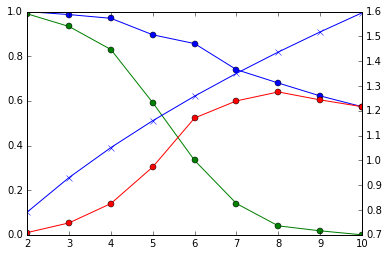

In [49]:
n=10
nerr=[]
terr=[]
o=[]
fig,ax=subplots()
xi = range(2,n+1)
for d in xi:
    xn,yn = gen_data(50*d,n)
    xt,yt = gen_data(50*d,n)
    v = VCLearner(dvc=d,n=n)
    v.fit(xn,yn)
    omega = np.sqrt(8/200*np.log((4*(2*200)**d+1)/.1))
    o.append(omega)
    nerr.append(v.score(xn,yn))
    terr.append(v.score(xt,yt))

ax.plot(xi,terr,'-o',xi,nerr,'-o',xi,array(terr)-nerr,'-o')
ax2 =ax.twinx()
ax2.plot(xi,o,'-x')

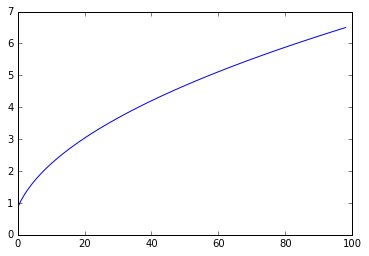

In [50]:
plot(map(lambda d:np.sqrt(8/100*np.log((4*(2*100)**d+1)/.1)),xrange(1,100)))

# Do interval partition Learning curves

In [51]:
train=pd.DataFrame(columns=['x','xb','y'])
train['x']=np.random.choice(range(2**10),size=90)
train.xb= train.x.map('{0:010b}'.format)
train.y=train.xb.map(f_target)
train.sort(columns=['x'],inplace=True)

D:\Miniconda64\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [52]:
test=pd.DataFrame(columns=['x','xb','y'])
test['x']=np.random.choice(range(2**10),size=500)
test.xb= test.x.map('{0:010b}'.format)
test.y=test.xb.map(f_target)
test.sort(columns=['x'],inplace=True)

D:\Miniconda64\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [53]:
partition=sorted([(sum(map(int,list(i))),int(i,2)) for i in VCLearner(dvc=3,n=8).h.keys()],key=lambda i:i[1])
pval=pd.Series(*zip(*partition))
pval[1023]=2
pfunc=pval.reindex(index=range(2**10)).interpolate('nearest')

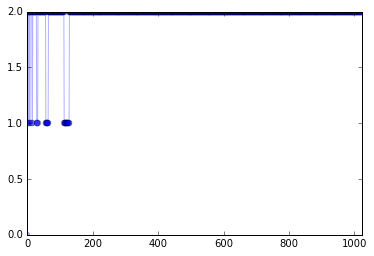

In [54]:
pfunc.plot(marker='o',alpha=.3)

In [55]:
def trainer(train,dvc=4):  
    func = pd.Series(index=range(1024))
    tmp=train.groupby(pd.cut(train.x,range(0,1024,1024//dvc)+[1023])).mean()
    func.iloc[-1]=tmp.y[-1]
    func.iloc[0]=tmp.y[0]
    for n,i in enumerate(tmp.index):
        func.iloc[int(i[i.find(',')+1:-1])] = tmp.iloc[n]['y']
    fi=func.interpolate('nearest')
    return fi

training err  6.91666666667
testing err  3.20828525413


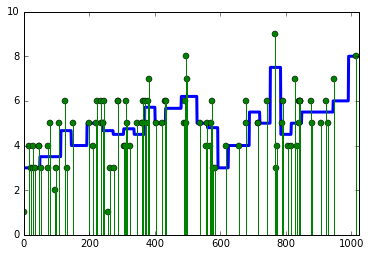

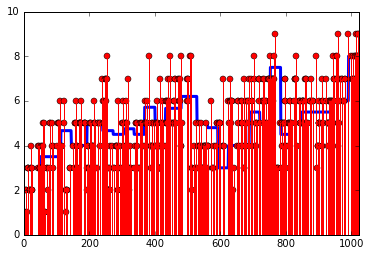

In [56]:
fi=trainer(train,32)
fi.plot(lw=3.)
stem(train.x,train.y,markerfmt='go',linefmt='g-')
axis(ymax=10,ymin=0)
print 'training err ',mean((fi[train.x]-train.y)**2)
figure()
fi.plot(lw=3.)
axis(ymax=10,ymin=0)
stem(test.x,test.y,markerfmt='ro',linefmt='r-')
print 'testing err ',mean((fi[test.x]-test.y)**2)

In [57]:
for d in [4,8,16,24,32]:
    fi=trainer(train,d)
    print 'training err ',mean((fi[train.x]-train.y)**2),
    print 'testing err ',mean((fi[test.x]-test.y)**2)


training err  3.99532312925 testing err  3.23861249273
training err  5.36848958333 testing err  3.24167256421
training err  6.63271604938 testing err  3.20806330389
training err  6.92361111111 testing err  3.38405973966
training err  6.91666666667 testing err  3.20828525413


## Adaptive intervals

In [58]:
def atrainer(train,dvc):
    le,re=train.x.reshape(dvc,-1)[:,[0,-1]].T
    val = train.y.reshape(dvc,-1).mean(axis=1).round()
    func = pd.Series(index=range(1024))
    func[le]=val
    func[re]=val
    func.iloc[0]=0
    func.iloc[-1]=0
    fi=func.interpolate('nearest')
    return fi

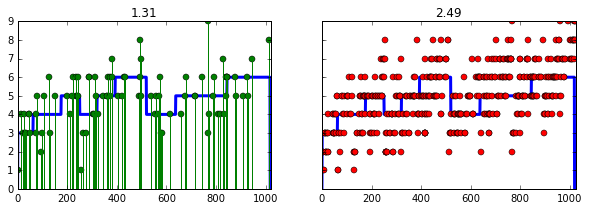

In [59]:
n=train.shape[0]
divisors=arange(1,n+1)[(n % arange(1,n+1))==0]
fig,axs=subplots(1,2,sharex=True,sharey=True)
fig.set_size_inches((10,3))
fi=atrainer(train,divisors[len(divisors)//2])
# fi=atrainer(train,36)
fi.plot(ax=axs[0],lw=3.)
axs[0].stem(train.x,train.y,markerfmt='go',linefmt='g-')
axs[0].set_title('%3.3g'%(mean((fi[train.x].values-train.y.values)**2)))
fi.plot(ax=axs[1],lw=3.)
axs[1].plot(test.x,test.y,'or')
axs[1].set_title('%3.3g'%(mean((fi[test.x].values-test.y.values)**2)))

In [60]:
otrn=[]
otst=[]
for i in divisors: # loop over divisors
    fi=atrainer(train,i)
    otrn.append((mean((fi[train.x].values-train.y.values)**2)))
    otst.append((mean((fi[test.x].values-test.y.values)**2)))

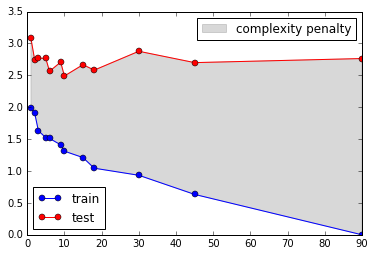

In [61]:
import matplotlib.patches as mpatches
fig,ax=subplots()
ax.plot(divisors,otrn,'-o',label='train')
ax.plot(divisors,otst,'-or',label='test')
ax.fill_between(divisors,otrn,otst,color='gray',alpha=.3)
# ax.legend(loc=0)
gray_patch = mpatches.Patch(color='gray', label='complexity penalty',alpha=.3)
gray_legend=ax.legend(handles=[gray_patch],loc=1,fontsize=12)
ax.legend(loc=0)
ax.add_artist(gray_legend)

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## One dimensional clustering example using scikit learn API

In [63]:
class ClusterInterval(object):
    def __init__(self,dvc=3):
        self._dvc = dvc
    def fit(self,x,y):
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        n=x.shape[0]
        dvc = self._dvc
        divisors=arange(1,n+1)[(n % arange(1,n+1))==0]
        le,re=x.reshape(dvc,-1)[:,[0,-1]].T
        val = y.reshape(dvc,-1).mean(axis=1).round()
#         val = y.reshape(dvc,-1).mean(axis=1)
        func = pd.Series(index=range(1024))
        func[le]=val
        func[re]=val
        func.iloc[0]=0
        func.iloc[-1]=0
        fi=func.interpolate('nearest')
        fi.name='predict'
        self._fi = fi
        self._divisors = divisors
    
    def score(self,x,y):
        fi = self._fi
        return (mean((fi[x].values-y)**2))

    def predict(self,x):
        return self._fi[x]
    
    def get_params(self,deep=True):
        return dict(dvc=self._dvc)
    def plot(self,**kwds):
        self._fi.plot(**kwds)      

In [64]:
train=pd.DataFrame(columns=['x','xb','y'])
train['x']=np.random.choice(range(2**10),size=512)
train.xb= train.x.map('{0:010b}'.format)
train.y=train.xb.map(f_target)
# train.y=train.xb.map(lambda i:10*np.sin(int(i,2)/1024*2*pi)).values
train.sort(columns=['x'],inplace=True)

D:\Miniconda64\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<module 'matplotlib.pyplot' from 'D:\Miniconda64\lib\site-packages\matplotlib\pyplot.pyc'>

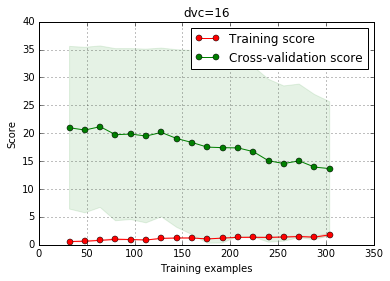

In [65]:
dvc=16
x = ClusterInterval(dvc)
plot_learning_curve(x,'dvc=%d'%(dvc),train.x.values,train.y.values,
                    train_sizes=range(dvc*2,int(train.shape[0]*.6),dvc))

In [66]:
x = ClusterInterval(8)
idx=train_test_split(train.x.values,train.y.values,test_size=128)
x.fit(idx[0],idx[2])
print 'training score ',x.score(idx[0],idx[2])
print 'testing score ',x.score(idx[1],idx[3])

training score  5.41145833333
testing score  5.109375


In [67]:
train=pd.DataFrame(columns=['x','xb','y'])
train['x']=np.random.choice(range(2**10),size=100)
train.xb= train.x.map('{0:010b}'.format)
train.y=train.xb.map(f_target)
train.sort(columns=['x'],inplace=True)

D:\Miniconda64\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


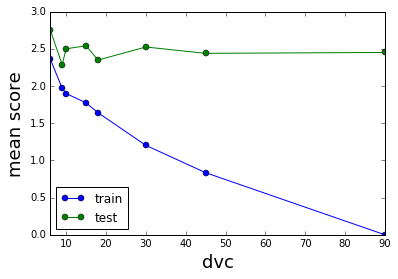

In [68]:
tts = pd.DataFrame(index=[6,9,10,15,18,30,45,90],columns=['train','test'])
tsdict={}
for dvc in tts.index:
    x = ClusterInterval(dvc)
    nscore=[]
    tscore=[]
    for i in range(100):
        idx=train_test_split(train.x.values,train.y.values,test_size=10)
        x.fit(idx[0],idx[2])
        nscore.append(x.score(idx[0],idx[2]))
        tscore.append(x.score(idx[1],idx[3]))
    tts.ix[dvc]['train']=mean(nscore)
    tts.ix[dvc]['test']=mean(tscore)
tts.plot(marker='o')
xlabel("dvc",fontsize=18)
ylabel('mean score',fontsize=18)

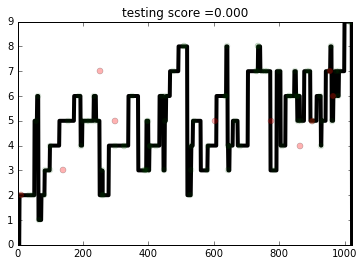

In [69]:
fig,ax=subplots()
# ax.axis(ymax=10)
x.plot(ax=ax,lw=4,color='k')
ax.plot(idx[0],idx[2],'go',alpha=.1)
ax.set_title("testing score ={0:3.3f}".format(x.score(idx[0],idx[2])))
ax.plot(idx[1],idx[3],'ro',alpha=.3)

training score  0.0


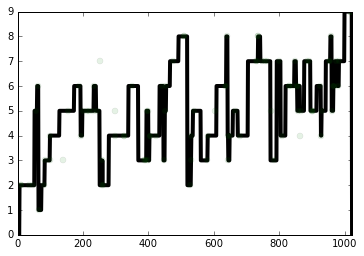

In [70]:
fig,ax=subplots()
# ax.axis(ymax=10) 
x.plot(ax=ax,lw=4,color='k')
ax.plot(train.x,train.y,'go',alpha=.1)
print 'training score ',x.score(idx[0],idx[2])

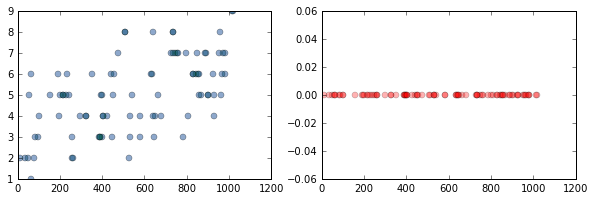

In [71]:
fig,axs=subplots(1,2)
fig.set_size_inches((10,3))
ax=axs[0]
ax.plot(idx[0],x.predict(idx[0]),'o',alpha=.3)
ax.plot(idx[0],idx[2],'o',alpha=.2)
axs[1].plot(idx[0],x.predict(idx[0])-idx[2],'ro',alpha=.3)
# ax2.axis(ax.axis())

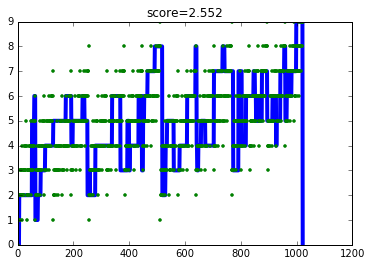

In [72]:
df = pd.DataFrame(index=arange(1023),columns=['y'])
# df.y = 10*np.sin(df.index.values/1024*2*pi)
df['y']=f_target(df.index.map(lambda i: ('{0:010b}'.format(i))))
plot(df.index,x.predict(df.index),df.index,df.y,'.',lw=4.)
title('score=%3.3f'%(x.score(df.index,df.y)))

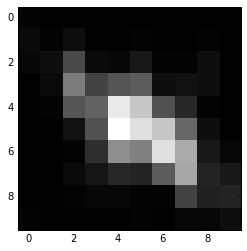

In [73]:
cmx=confusion_matrix(df.y,x.predict(df.index))
imshow(cmx-0*np.diag(cmx.diagonal()),interpolation='nearest',cmap=cm.gray)

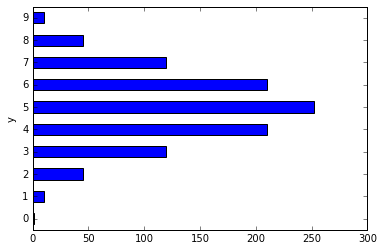

In [74]:
df.groupby('y')['y'].count().plot(kind='barh')

0.355445101523
0.331314376057
0.504542568521
0.459056723682


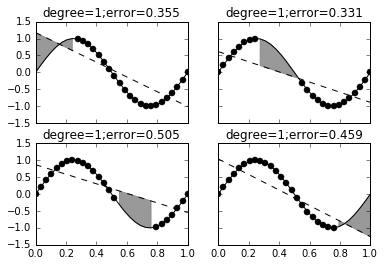

In [75]:
from sklearn.cross_validation import KFold
xi = np.linspace(0,1,30)
yi = np.sin(2*np.pi*xi)
fig,axs=subplots(2,2,sharex=True,sharey=True)
deg = 1
for ax,(train_idx,test_idx) in zip(axs.flat,KFold(len(xi),4)):
    ax.plot(xi,yi,xi[train_idx],yi[train_idx],'ok',color='k')
    p = np.polyfit(xi[train_idx],yi[train_idx],deg)
    pval = np.polyval(p,xi)
    ax.plot(xi,pval,'--k')
    error = np.mean((pval[test_idx]-yi[test_idx])**2)
    print error
    ax.set_title('degree=%d;error=%3.3g'%(deg,error))
    ax.fill_between(xi[test_idx],pval[test_idx],yi[test_idx],color='gray',alpha=.8)    

In [76]:
from sklearn.metrics import  make_scorer, mean_squared_error

Xi = xi.reshape(-1,1)
Yi = yi.reshape(-1,1)
lf = LinearRegression()
scores = cross_val_score(lf,Xi,Yi,cv=4,scoring=make_scorer(mean_squared_error))
scores

array([ 0.3554451 ,  0.33131438,  0.50454257,  0.45905672])

In [77]:
from sklearn.grid_search import GridSearchCV

# Construct learning curves for linear model

In [78]:
from scipy import stats
def gen_sindata(n=2):
    x=stats.uniform(-1,1)
    v = x.rvs((n,1))
    y = np.sin(np.pi*v)
    return (v,y)

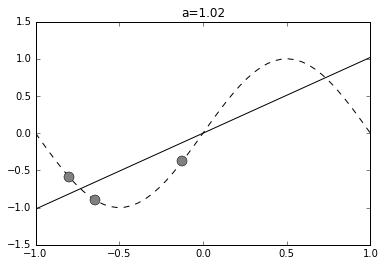

In [79]:
lr = LinearRegression(fit_intercept=False)
xi=np.linspace(-1,1,50)
yi= np.sin(pi*xi)
xg,yg = gen_sindata(3)
lr.fit(xg,yg)
plot(xi,yi,'--k')
plot(xg,yg,'o',ms=10,color='gray')
plot(xi,lr.predict(xi.reshape(-1,1)),color='k')
title('a=%3.3g'%(lr.coef_))

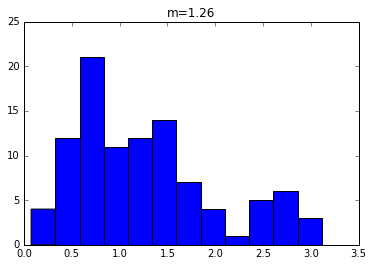

In [80]:
o=[]
for i in range(100):
    xg,yg = gen_sindata(3)
    o.append((np.dot(xg.T,yg)/np.dot(xg.T,xg))[0,0])
hist(o,12)
title('m=%3.3g'%(mean(o)))

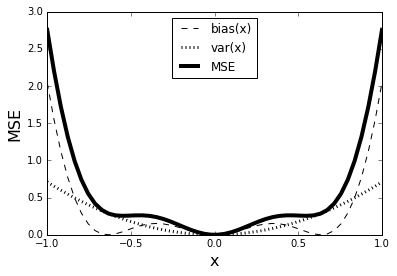

In [81]:
fig,ax=subplots()
ax.plot(xi,(1.43*xi-yi)**2,'--k',label='bias(x)')
ax.plot(xi,0.71*(xi)**2,':k',label='var(x)',lw=3.)
# ax2=ax.twinx()
ax.plot(xi,(1.43*xi-yi)**2+0.71*(xi)**2,color='k',lw=4,label='MSE')
ax.legend(fontsize=12,loc=0)
ax.set_ylabel('MSE',fontsize=16)
ax.set_xlabel('x',fontsize=16)

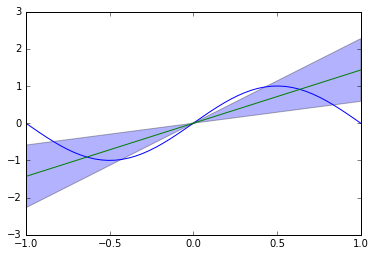

In [82]:
fig,ax=subplots()
ax.plot(xi,yi)
ax.plot(xi,1.43*xi)
ax.fill_between(xi,1.43*xi+sqrt(0.71*xi**2),1.43*xi-sqrt(0.71*xi**2),alpha=.3)